# Unsupervised Learning

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [2]:
np.random.seed(seed=42)

In [3]:
X = np.empty((150, 2))
y = np.empty((150,))

X[:50, 0] = np.random.normal(loc=0.0, scale=0.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=0.3, size=50)
y[:50] = np.full(fill_value=0, shape=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=0.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=0.2, size=50)
y[50:100] = np.full(fill_value=1, shape=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=0.5, size=50)
y[100:150] = np.full(fill_value=2, shape=50)

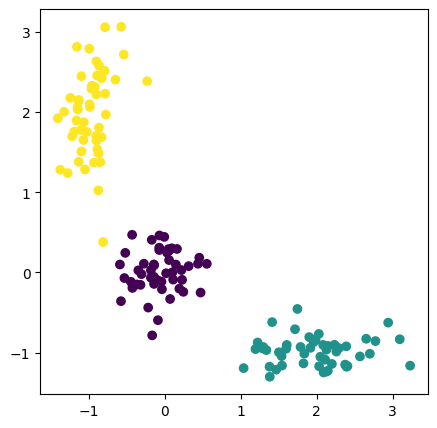

In [4]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)

## K-means Clustering

The k-means algorithm clusters data by trying to separate samples in $k$ groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large numbers of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of $n$ samples $X$ into $k$ disjoint clusters $C$, each described by the mean $c_j$ of the samples (centroid) in the cluster. The means are commonly called the cluster "centroids"; note that they are not, in general, points from $X$, although they live in the same space.

The k-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion:
$$\text{WSS} = \sum_{i=0}^n \text{min}_{c_j \in C} ||x_i - c_j||^2.$$

K-means is often referred to as Lloyd’s algorithm. In basic terms, the algorithm has three steps. The first step chooses the initial centroids, with the most basic method being to choose $k$ samples from the dataset $X$. After initialization, k-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly.

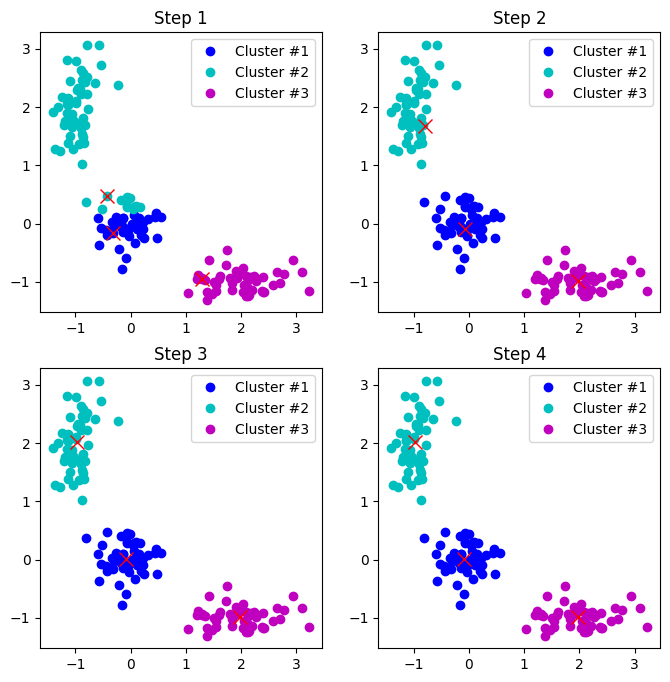

In [5]:
# Randomly initialize 3 centroids.
k = 3
indices = np.random.choice(X.shape[0], k, replace=False)
centroids = X[indices].copy()

history = []
history.append(centroids)

for i in range(4):
    # Calculate the distances from the points to the centroid.
    distances = cdist(X, centroids)
    # Find the closest centroid to each point.
    labels = distances.argmin(axis=1)
    
    # Recompute the centroids.
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    history.append(centroids)


plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], "bo", label="Cluster #1")
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], "co", label="Cluster #2")
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], "mo", label="Cluster #3")
    plt.plot(history[i][:, 0], history[i][:, 1], "rx", ms=10)
    plt.legend(loc=0)
    plt.title(f"Step {i + 1}");

In [6]:
inertias = []
iterations = range(1, 10)
for k in iterations:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias.append(np.sqrt(kmeans.inertia_))

Text(0, 0.5, '$WSS$')

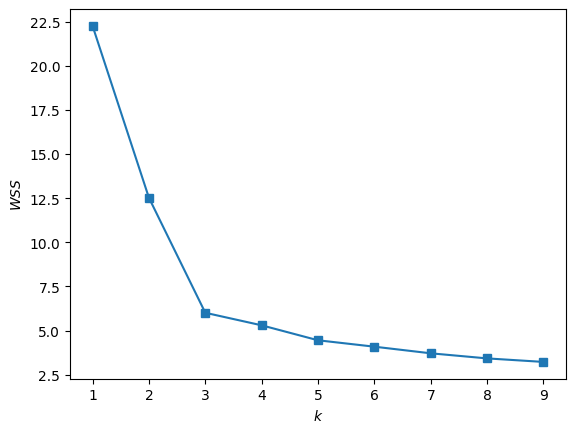

In [7]:
plt.plot(iterations, inertias, marker="s")
plt.xlabel("$k$")
plt.ylabel("$WSS$")

In [8]:
knee_locator = KneeLocator(iterations, inertias, curve="convex", direction="decreasing")

In [9]:
print(f"k: {knee_locator.knee}, WSS: {inertias[knee_locator.knee - 1]}")

k: 3, WSS: 6.004992207725499


Text(0, 0.5, '$WSS$')

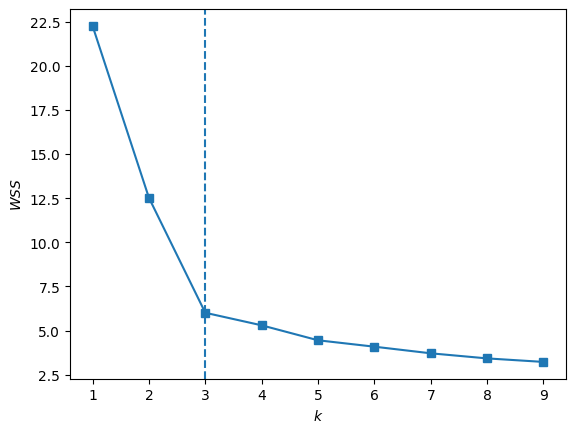

In [98]:
plt.plot(iterations, inertias, marker="s")
plt.axvline(x=knee_locator.knee, ls="--", label="elbow")
plt.xlabel("$k$")
plt.ylabel("$WSS$")

Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

+ Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

+ Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called "curse of dimensionality"). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.

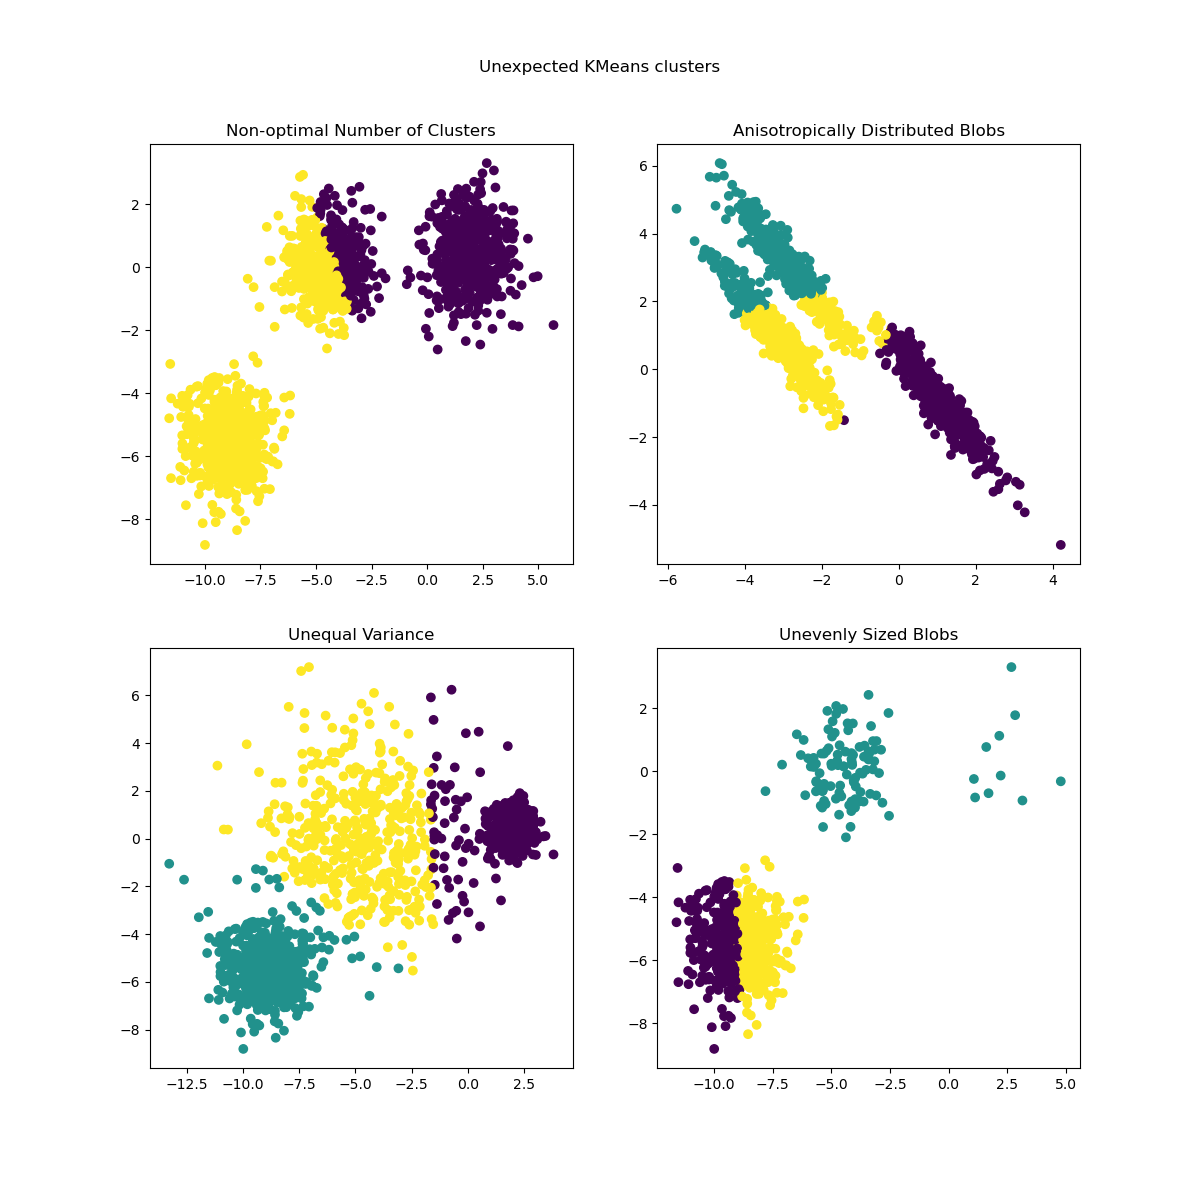

## Hierachical Clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.

The agglomerative clustering is a type of hierarchical clustering that uses a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:

+ **Ward** minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

+ **Maximum** or **complete** linkage minimizes the maximum distance between observations of pairs of clusters.

+ **Average** linkage minimizes the average of the distances between all observations of pairs of clusters.

+ **Single** linkage minimizes the distance between the closest observations of pairs of clusters.

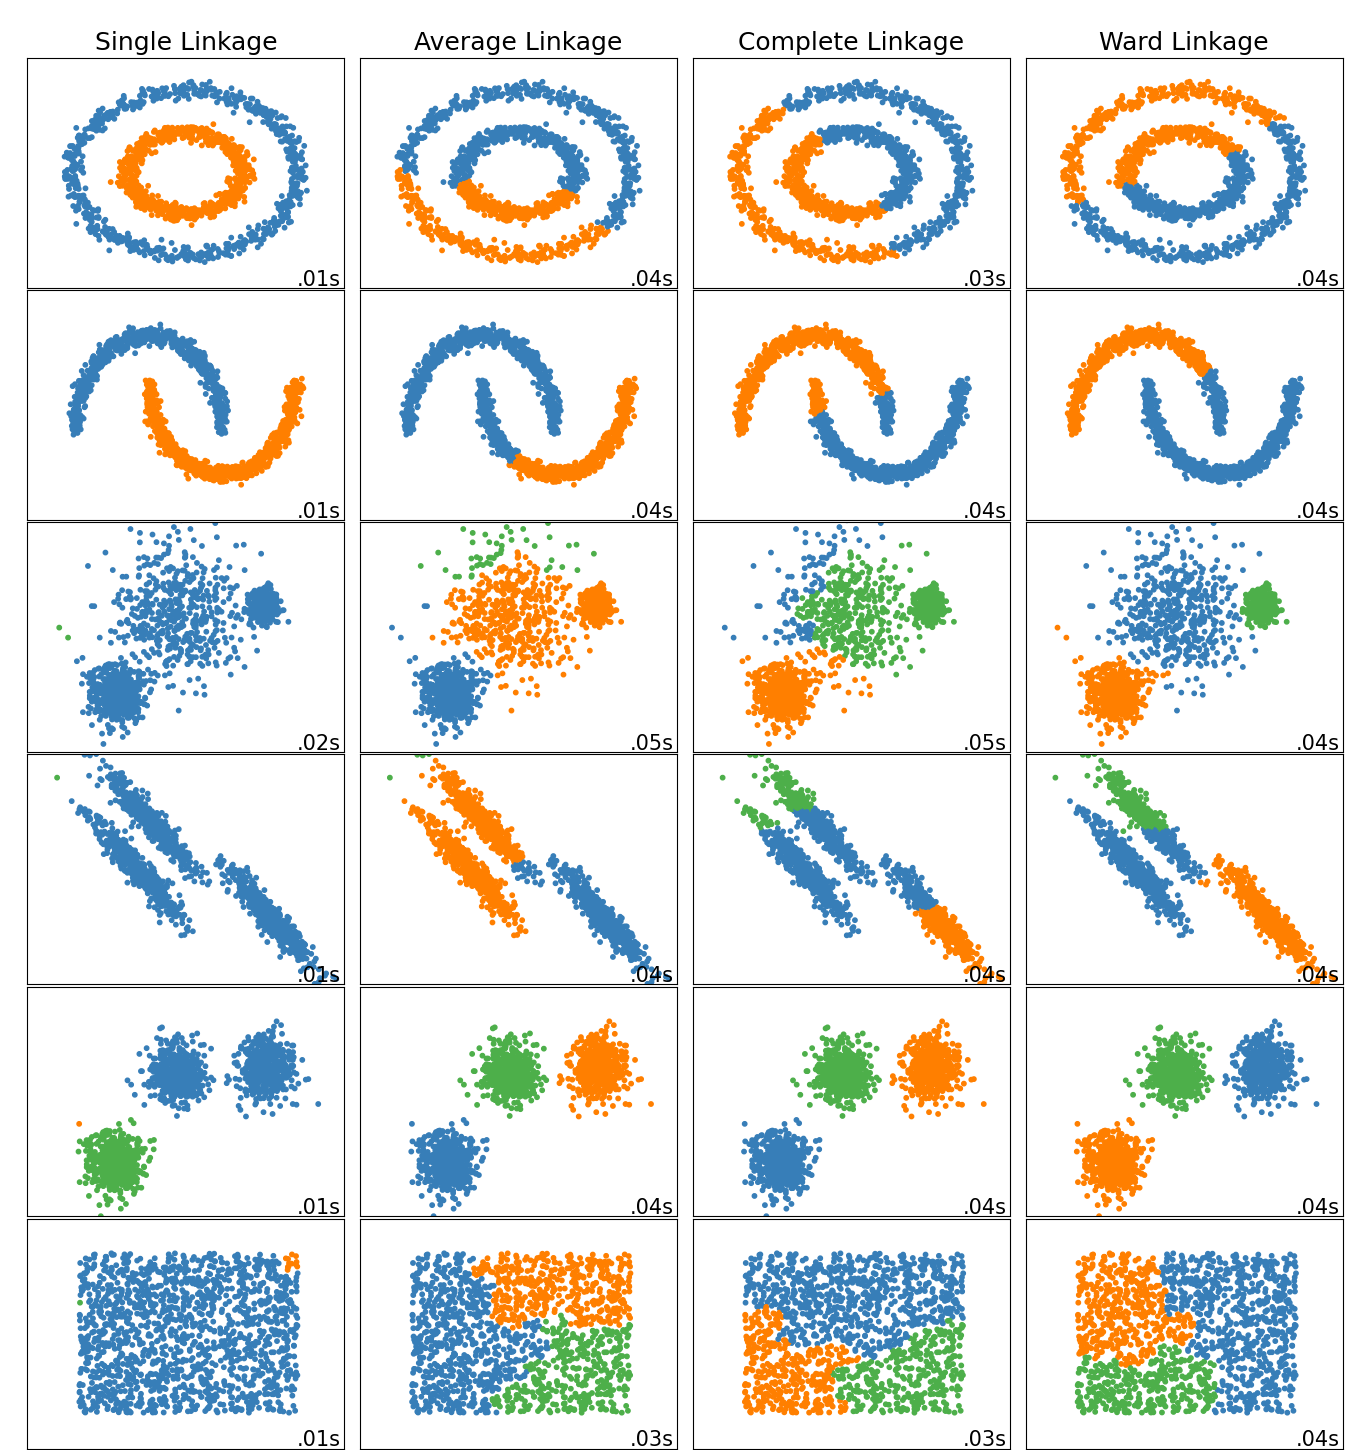

Agglomerative cluster has a "rich get richer" behavior that leads to uneven cluster sizes. In this regard, single linkage is the worst strategy, and Ward gives the most regular sizes. However, the affinity (or distance used in clustering) cannot be varied with Ward, thus for non Euclidean metrics, average linkage is a good alternative. Single linkage, while not robust to noisy data, can be computed very efficiently and can therefore be useful to provide hierarchical clustering of larger datasets. Single linkage can also perform well on non-globular data.

In [10]:
X = np.empty((150, 2))
y = np.empty((150,))

X[:50, 0] = np.random.normal(loc=0.0, scale=0.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=0.3, size=50)
y[:50] = np.full(fill_value=0, shape=50)

X[50:100, 0] = np.random.normal(loc=3.0, scale=0.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=0.2, size=50)
y[50:100] = np.full(fill_value=1, shape=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=0.9, size=50)
y[100:150] = np.full(fill_value=2, shape=50)

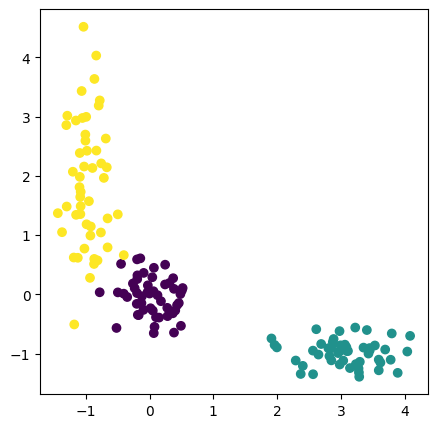

In [11]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)

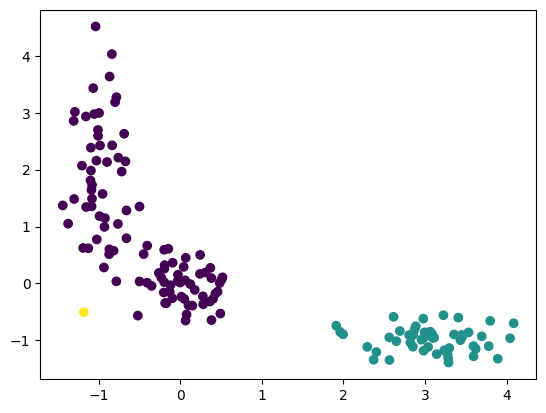

In [12]:
clustering = AgglomerativeClustering(n_clusters=3, linkage="single").fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)

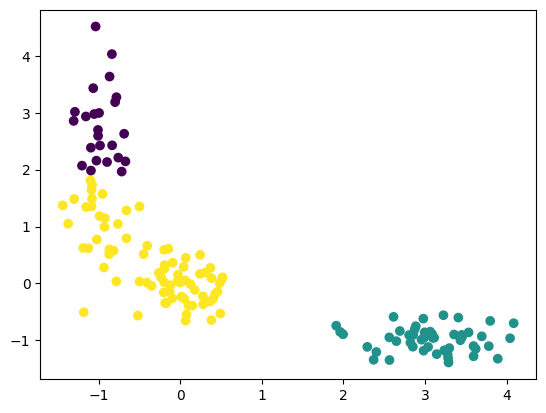

In [13]:
clustering = AgglomerativeClustering(n_clusters=3, linkage="average").fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)

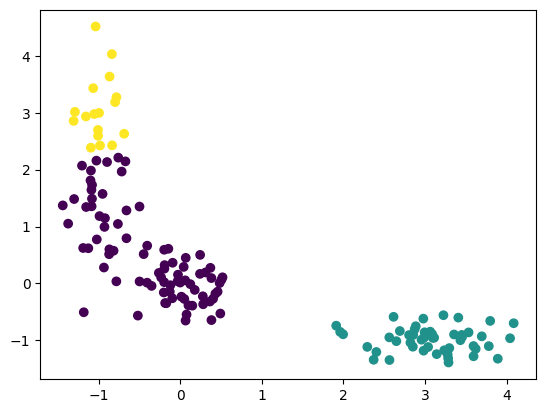

In [14]:
clustering = AgglomerativeClustering(n_clusters=3, linkage="complete").fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)

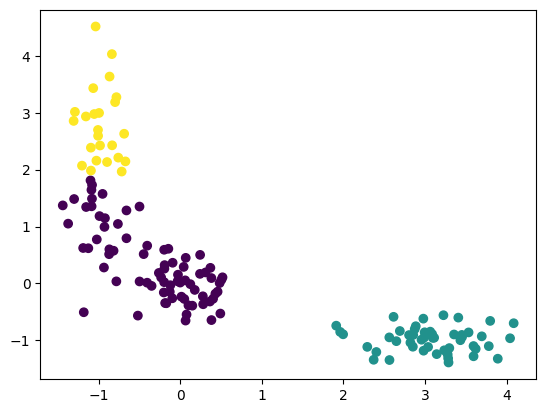

In [15]:
clustering = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)

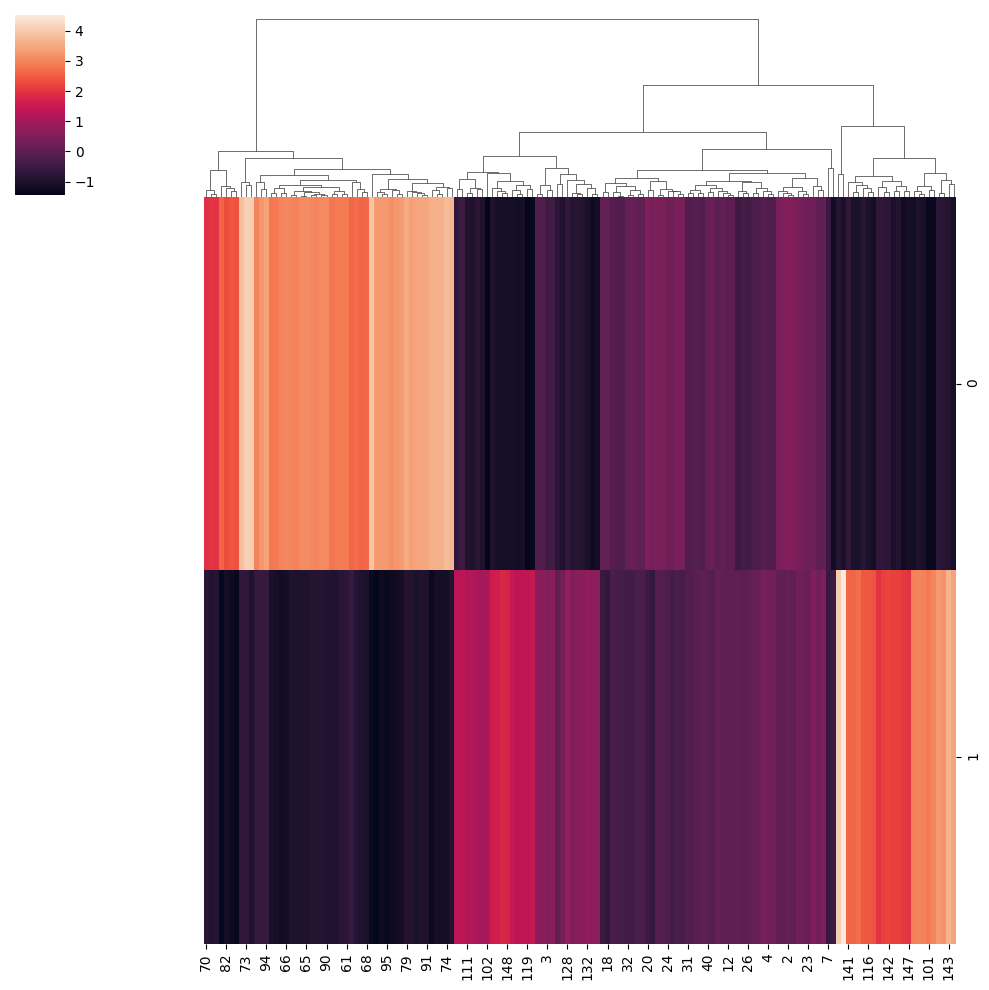

In [20]:
sns.clustermap(X.T, method="average", metric="euclidean", row_cluster=False)

## Density-based Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) finds core samples in regions of high density and expands clusters from them. This algorithm is good for data which contains clusters of similar density.

In [21]:
X = np.empty((150, 2))
y = np.empty((150,))

X[:50, 0] = np.random.normal(loc=-1.0, scale=0.7, size=50)
X[:50, 1] = np.random.normal(loc=-2.0, scale=0.5, size=50)
y[:50] = np.full(fill_value=0, shape=50)

X[50:100, 0] = np.random.normal(loc=7.0, scale=1.0, size=50)
X[50:100, 1] = np.random.normal(loc=-3.0, scale=3.0, size=50)
y[50:100] = np.full(fill_value=1, shape=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=3.0, size=50)
X[100:150, 1] = np.random.normal(loc=5.0, scale=1.0, size=50)
y[100:150] = np.full(fill_value=2, shape=50)

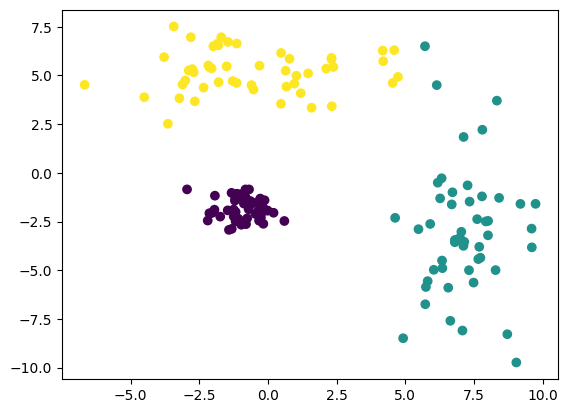

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y)

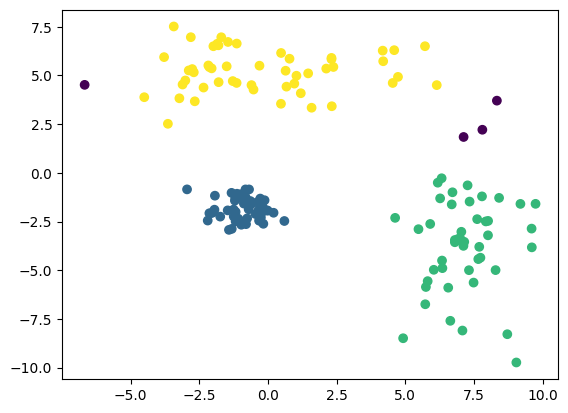

In [23]:
clustering = DBSCAN(eps=2.2, min_samples=4).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)

## Text Clustering

In [24]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

In [25]:
model = SentenceTransformer("all-mpnet-base-v2")

In [27]:
sentences = [
    # Smartphones
    "I like my phone, it is very good.",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US.",
    "Global warming is real!",

    # Food and health
    "An apple a day, keeps the doctor away.",
    "Eating strawberries is healthy.",
    "Is paleo healthier than keto diet?",

    # Age-related questions
    "How old are you?",
    "What is your age?",
]

In [29]:
embeddings = model.encode(sentences)

In [32]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  plot = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="Blues")
  plot.set_xticklabels(labels, rotation=rotation)
  plot.set_title("Semantic Textual Similarity")

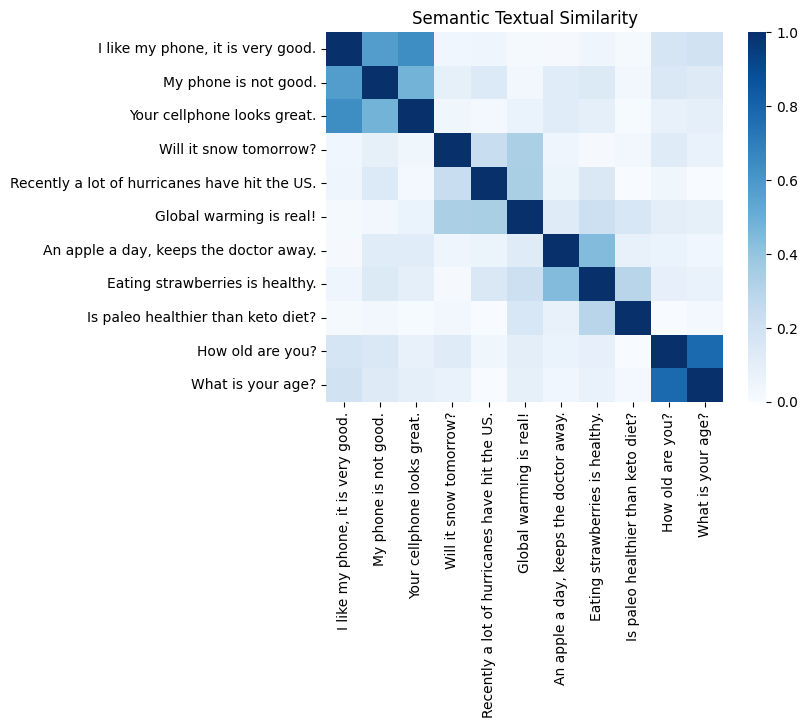

In [33]:
plot_similarity(sentences, embeddings, 90)

In [42]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

In [43]:
labels = KMeans(init="k-means++", n_clusters=4, random_state=42).fit_predict(reduced_embeddings)

In [44]:
labels

array([2, 2, 2, 3, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

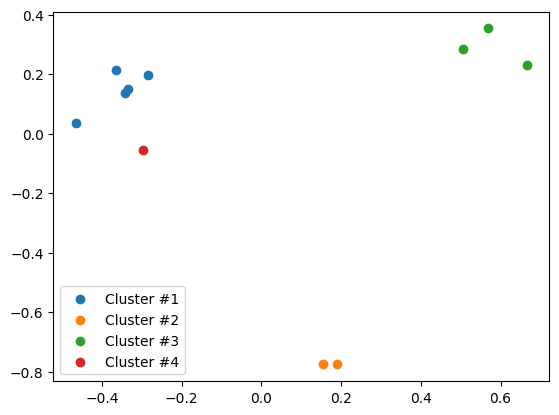

In [45]:
for label in np.unique(labels):
    plt.scatter(
        reduced_embeddings[labels == label, 0],
        reduced_embeddings[labels == label, 1],
        label=f"Cluster #{label + 1}"
    )
    plt.legend()

In [46]:
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings)

In [47]:
labels = KMeans(init="k-means++", n_clusters=4, random_state=42).fit_predict(reduced_embeddings)

In [48]:
labels

array([2, 2, 2, 0, 0, 0, 1, 1, 1, 3, 3], dtype=int32)

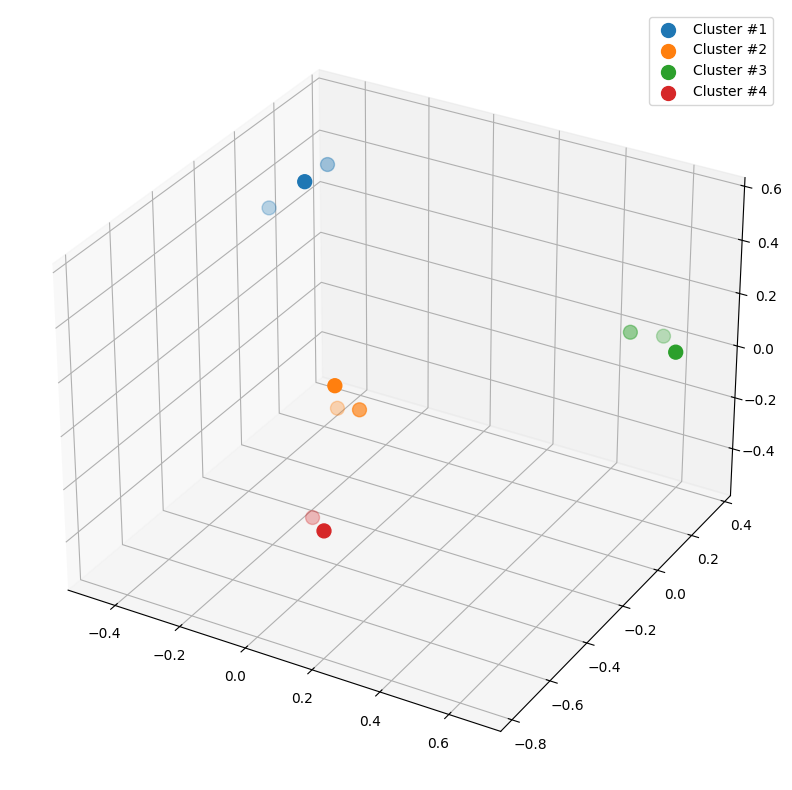

In [50]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
for label in np.unique(labels):
    ax.scatter(
        reduced_embeddings[labels == label, 0],
        reduced_embeddings[labels == label, 1], 
        reduced_embeddings[labels == label, 2],
        label=f"Cluster #{label + 1}",
        s=100,
    )
ax.legend()